# PatchTST Evaluation Notebook

MAE  : 5.1736
RMSE : 7.6428
Directional accuracy: 57.36%


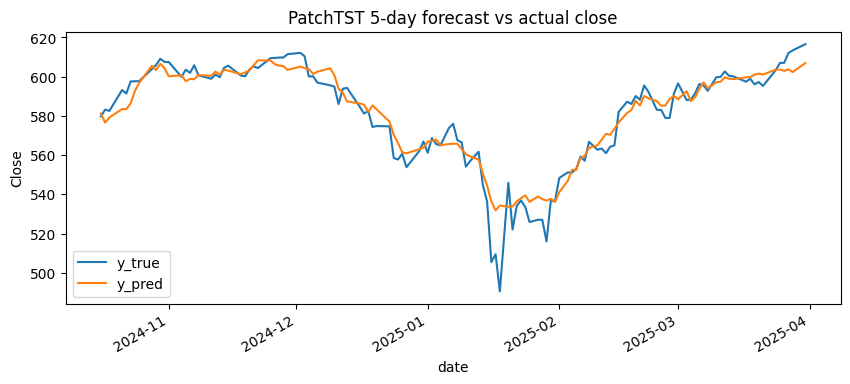

Naive MAE  : 5.0015
Naive RMSE : 8.4436
Improvement in MAE : -0.1721
Improvement in RMSE: +0.8008


In [7]:
# PatchTST – hold‑out evaluation
#
# Load the CSV produced by eval_patchtst.py, compute error metrics,
# plot predictions vs actuals, and show a naive baseline for comparison.

import pandas as pd, numpy as np, matplotlib.pyplot as plt

csv_path = "../preds_vs_actuals.csv"   # change if needed
p = pd.read_csv(csv_path, parse_dates=["date"])

# only recent data
cut = "2024-10-16"
p = p[p["date"] >= cut]

# Basic error metrics
p["error"] = p.y_pred - p.y_true
mae  = np.abs(p.error).mean()
rmse = np.sqrt(np.mean(p.error ** 2))
print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")

# Directional accuracy
ups_true  = np.sign(p.y_true.diff())
ups_pred  = np.sign(p.y_pred.diff())
dir_acc = (ups_true == ups_pred).mean() * 100
print(f"Directional accuracy: {dir_acc:.2f}%")

# Timeline plot
p.set_index("date")[["y_true","y_pred"]].plot(
    figsize=(10,4), title="PatchTST 5-day forecast vs actual close")
plt.ylabel("Close")
plt.show()

# Naive baseline comparison
p["naive_pred"] = p.y_true.shift(1)
naive_mae  = np.abs(p.naive_pred - p.y_true).mean()
naive_rmse = np.sqrt(np.mean((p.naive_pred - p.y_true)**2))
print(f"Naive MAE  : {naive_mae:.4f}")
print(f"Naive RMSE : {naive_rmse:.4f}")
print(f"Improvement in MAE : {naive_mae - mae:+.4f}")
print(f"Improvement in RMSE: {naive_rmse - rmse:+.4f}")


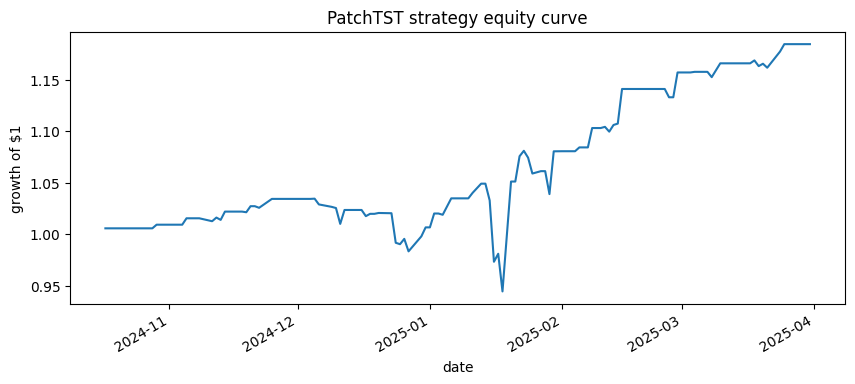

CAGR   : 39.21%
Sharpe : 1.60


In [8]:
# ─────────────────────────────────────────────────────────────
# Trading signal & Sharpe ratio
# ─────────────────────────────────────────────────────────────

# daily close-to-close return of the underlying
p["ret"] = p.y_true.pct_change(fill_method=None)

# simple long-only signal:
#    go long if model predicts the *next* close > today’s close
p["signal"] = (p.y_pred.shift(1) > p.y_true.shift(1)).astype(int)

# strategy return = signal × next-day return
p["strategy"] = p.signal * p.ret

# cumulative equity curve
p["equity"] = (1 + p.strategy).cumprod()
p.set_index("date")["equity"].plot(figsize=(10,4),
                                   title="PatchTST strategy equity curve")
plt.ylabel("growth of $1"); plt.show()

# performance metrics
trading_days = 252
mean_ret = p.strategy.mean()
std_ret  = p.strategy.std()
sharpe   = (mean_ret / std_ret) * np.sqrt(trading_days)

cagr = (p.equity.iat[-1]) ** (trading_days / len(p)) - 1

print(f"CAGR   : {cagr:.2%}")
print(f"Sharpe : {sharpe:.2f}")
